# M5 Forecast MLiP The Kaggle Talents



## Important Imports

In [0]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb

## Load data

In [2]:
""" Loading data on Google Cloud Platform """ 
# selling_prices = pd.read_csv("sell_prices.csv")
# sample_submission = pd.read_csv("sample_submission.csv")
# sales = pd.read_csv("sales_train_validation.csv")
# calendar = pd.read_csv("calendar.csv")

' Loading data on Google Cloud Platform '

In [3]:
""" Loading data on Kaggle """ 
# path = "../input/m5-forecasting-accuracy"
# selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
# sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))
# sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))
# calendar = pd.read_csv(os.path.join(path, "calendar.csv"))

' Loading data on Kaggle '

In [4]:
""" Loading data on Google Colab """ 
from google.colab import drive
drive.mount("/content/drive/")
path =  "/content/drive/My Drive/Colab Notebooks/"

selling_prices = pd.read_csv(path + 'sell_prices.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')
sales = pd.read_csv(path + 'sales_train_validation.csv')
# sales = pd.read_csv(path + 'sales_train_evaluation.csv')
calendar = pd.read_csv(path + 'calendar.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Prepare Calendar Data

In [5]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    """ Reshape the calendar file """ 
    #Remove "date" & "weekday" since "wm_yr_wk" & "wday" contain the same info anyway
    #Remove "event_type_1" & "event_type_2" since "event_name_1" & "event_name_2" contain the same info anyway
    df = df.drop(["date", "weekday", "event_type_1", "event_type_2"], axis=1)
    #Rename d_1, d_2, d_n, to 1, 2, n
    df = df.assign(d = df.d.str[2:].astype(int))
    #Make data ordinal (represented by integer)
    to_ordinal = ["event_name_1", "event_name_2"] 
    df[to_ordinal] = df[to_ordinal].fillna("1")
    df[to_ordinal] = OrdinalEncoder(dtype="int").fit_transform(df[to_ordinal]) + 1
    #Decrease size of some integers
    to_int8 = ["wday", "month", "snap_CA", "snap_TX", "snap_WI"] + to_ordinal
    to_int16 = ["year", "wm_yr_wk"]
    df[to_int8] = df[to_int8].astype("int8")
    df[to_int16] = df[to_int16].astype("int16")
    return df

calendar = prep_calendar(calendar)

""" When testing features use maxtake to decrease data size """ 
# MAXTAKE = 1000
# selling_prices = selling_prices[0:MAXTAKE]
# sample_submission = sample_submission[0:MAXTAKE]
# sales = sales[0:MAXTAKE]

print("###### Calendar ######")
display(calendar)
print("###### Selling Prices ######")
display(selling_prices)
print("###### Sample Submission ######")
display(sample_submission)
print("###### Sales ######")
display(sales)

###### Calendar ######


,wm_yr_wk,wday,month,year,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
0,11101,1,1,2011,1,1,1,0,0,0
1,11101,2,1,2011,2,1,1,0,0,0
2,11101,3,1,2011,3,1,1,0,0,0
3,11101,4,2,2011,4,1,1,1,1,0
4,11101,5,2,2011,5,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1964,11620,5,6,2016,1965,1,1,0,1,1
1965,11620,6,6,2016,1966,1,1,0,0,0
1966,11620,7,6,2016,1967,1,1,0,0,0
1967,11621,1,6,2016,1968,1,1,0,0,0


###### Selling Prices ######


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


###### Sample Submission ######


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


###### Sales ######


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,0,0,3,4,4,0,0,1,0,1,1,7,7,3,6,3,3,7,12,4,2,7,5,12,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,1,0,0,0,0,3,1,1,1,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,2,7,5,3,5,20,8,10,3,3,4,7,2,3,5,6,3,4,1,2,5,1,2,2,2,...,1,1,2,0,0,2,0,0,0,2,0,1,1,0,0,0,0,1,1,2,1,4,0,0,2,2,4,0,0,0,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,2,1,1,2,4,3,0,0,0,0,0,1,1,2,1,1,1,1,2,0,1,0,3,0,0,1,0,0,1,0,3,1,3


## Prepare Data & Features

In [0]:
from sklearn.model_selection import train_test_split

LAGS = [7, 28]
WINDOWS = [7, 28]
FIRST = 1914
LENGTH = 28
DF_DROP = 1000

def roll_lag_features(df):
    """ Derive features from sales data and price data """    
    for lag in LAGS:
        df[f'lag_t{lag}'] = df.groupby('id')['demand'].transform(lambda x: x.shift(lag)).astype("float32")
        df[f'price_lag_t{lag}'] = df.groupby('id')['sell_price'].transform(lambda x: x.shift(lag)).astype("float32")
        for w in WINDOWS:
            df[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id')[f'lag_t{lag}'].transform(lambda x: x.rolling(w).mean()).astype("float32")
            df[f'price_roll_mean_lag{lag}_w{w}'] = df.groupby('id')[f'price_lag_t{lag}'].transform(lambda x: x.rolling(w).mean()).astype("float32")
        
    return df

def roll_lag_features_eval(df):
    """ Same as roll_lag_features but for the step-by-step evaluation """
    out = df.groupby('id', sort=False).last()
    for lag in LAGS:
        out[f'lag_t{lag}'] = df.groupby('id', sort=False)['demand'].nth(-lag-1).astype("float32")
        out[f'price_lag_t{lag}'] = df.groupby('id')['sell_price'].nth(-lag-1).astype("float32")
        for w in WINDOWS:
            out[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id', sort=False)['demand'].nth(list(range(-lag-w, -lag))).groupby('id', sort=False).mean().astype("float32")
            out[f'price_roll_mean_lag{lag}_w{w}'] = df.groupby('id', sort=False)['sell_price'].nth(list(range(-lag-w, -lag))).groupby('id', sort=False).mean().astype("float32")            
    
    return out.reset_index()


def fancy_features(df):
    # df["price_mean"] = df.groupby('id')['lag_t7'].transform(lambda x: x.mean())
    # df["price_std"] = df.groupby('id')['sell_price'].transform(lambda x: x.std())
    # df["price_min"] = df.groupby('id')['sell_price'].transform(lambda x: x.min())
    # df["price_max"] = df.groupby('id')['sell_price'].transform(lambda x: x.max())
    # df["price_lag_1"] = df.groupby('id')['sell_price'].transform(lambda x: x.shift(1)).astype("float32")
    # df["price_momentum_30"] = df.groupby('id')['sell_price'].transform(lambda x: x.rolling(30).mean()).astype("float32")
    # df["price_norm"] = df['sell_price']/df['price_max']
    # df["sell_price"] = df["sell_price"].astype("float32")
    # df["price_lag_1"] = df.groupby('id')['sell_price'].transform(lambda x: x.shift(1)).astype("float32")
    # df["price_change_1"] = (df["price_lag_1"] - df["sell_price"]).astype("float32")
    # df["on_sale"] = df["sell_price"].apply(check_sale)
    # df['item_sold_avg'] = df.groupby('item_id')['demand'].transform('mean').astype(np.float16)
    # df['state_sold_avg'] = df.groupby('state_id')['demand'].transform('mean').astype(np.float16)
    # df['store_sold_avg'] = df.groupby('store_id')['demand'].transform('mean').astype(np.float16)
    # df['cat_sold_avg'] = df.groupby('cat_id')['demand'].transform('mean').astype(np.float16)
    # df['dept_sold_avg'] = df.groupby('dept_id')['demand'].transform('mean').astype(np.float16)
    # df['cat_dept_sold_avg'] = df.groupby(['cat_id','dept_id'])['demand'].transform('mean').astype(np.float16)
    # df['store_item_sold_avg'] = df.groupby(['store_id','item_id'])['demand'].transform('mean').astype(np.float16)
    # df['cat_item_sold_avg'] = df.groupby(['cat_id','item_id'])['demand'].transform('mean').astype(np.float16)
    # df['dept_item_sold_avg'] = df.groupby(['dept_id','item_id'])['demand'].transform('mean').astype(np.float16)
    # df['state_store_sold_avg'] = df.groupby(['state_id','store_id'])['demand'].transform('mean').astype(np.float16)
    # df['state_store_cat_sold_avg'] = df.groupby(['state_id','store_id','cat_id'])['demand'].transform('mean').astype(np.float16)
    # df['store_cat_dept_sold_avg'] = df.groupby(['store_id','cat_id','dept_id'])['demand'].transform('mean').astype(np.float16)
    return df

# def check_sale(price):
#     if (math.isnan(price)):
#         return False
#     if float(str(price)[-1]) >= 7.0:
#         return True
#     return False

def data_to_long(df):
    """ Prepare model data sets """  
    # Kick out old dates
    df = df.drop(["d_" + str(i+1) for i in range(DF_DROP)], axis=1)

    # Reshape to long
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(FIRST + i) for i in range(2 * LENGTH)])
    df = df.melt(id_vars=["id", "item_id", "store_id", "state_id", "dept_id", "cat_id"], var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int64"),
                   demand=df.demand.astype("float32"))
    return df

def join_calender_and_prices(df):
    """ Merge calendar and prices dataframes """ 
    df = df.merge(calendar, how="left", on="d")
    df = df.merge(selling_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
    df = df.drop(["wm_yr_wk"], axis=1)  
    return df

def remove_NA(df):
    """ Remove all rows that contain NA's because of windows and lags """ 
    df = df[df.d > (DF_DROP + max(LAGS) + max(WINDOWS))]
    return df

def prep_data(df):
    """ Prepare data for input to model """ 
    # Ordinal encoding of remaining categorical fields
    for v in ["item_id", "store_id", "state_id", "dept_id", "cat_id"]:
        df[v] = OrdinalEncoder(dtype="int").fit_transform(df[[v]]).astype("int16") + 1
    
    # Determine list of covariables
    x = list(set(df.columns) - {'id', 'd', 'demand'})
    
    # Split into test, valid, train
    test = df[df.d >= FIRST - max(LAGS) - max(WINDOWS)]
    df = df[df.d < FIRST]

    # Split into train and test set
    xtrain, xvalid, ytrain, yvalid = train_test_split(df[x], df["demand"], test_size=0.1, shuffle=True, random_state=54)
    train = lgb.Dataset(xtrain, label = ytrain)
    valid = lgb.Dataset(xvalid, label = yvalid)
    return train, valid, test, x

dat = data_to_long(sales)
dat = join_calender_and_prices(dat)
dat = roll_lag_features(dat)
# dat = fancy_features(dat)
dat = remove_NA(dat)
train, valid, test, x = prep_data(dat)

## Model Creation

[100]	valid_0's rmse: 2.21117
[200]	valid_0's rmse: 2.16402
[300]	valid_0's rmse: 2.14066
[400]	valid_0's rmse: 2.12405
[500]	valid_0's rmse: 2.11503
[600]	valid_0's rmse: 2.10873
[700]	valid_0's rmse: 2.10349
[800]	valid_0's rmse: 2.09939
[900]	valid_0's rmse: 2.09548
[1000]	valid_0's rmse: 2.09112
[1100]	valid_0's rmse: 2.08743
[1200]	valid_0's rmse: 2.08419
[1300]	valid_0's rmse: 2.08221
[1400]	valid_0's rmse: 2.07914
[1500]	valid_0's rmse: 2.07713
[1600]	valid_0's rmse: 2.07551
[1700]	valid_0's rmse: 2.07376


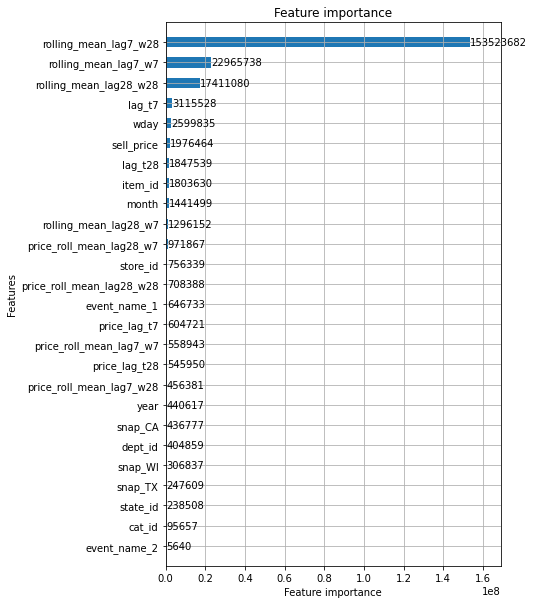

In [7]:
def fit_model(train, valid):
    """ Fit LightGBM model """
     
    params = {
        #OPTUNA 300BR TUNING PARAMETER SET

        #Chosen Parameters
        'metric': 'rmse',
        'objective': 'poisson',
        'seed': 200,
        'force_row_wise' : True,
        'learning_rate' : 0.1,
        'lambda': 0.1,
        'sub_row' : 0.7,
        'colsample_bytree': 0.77,

        #Optuna Optimized Paramaters
        'feature_fraction' : 0.8,
        'bagging_freq' : 3,
        'bagging_fraction' : 0.7,
        'num_leaves': 126,
        'lambda_l1': 1.3004607570673544e-05, 
        'lambda_l2': 0.10635526690556296,
        'min_child_samples': 20
    }

    fit = lgb.train(params, 
                    train, 
                    valid_sets = [valid],
                    num_boost_round = 1750, 
                    verbose_eval = 100)
                    # best_params=best_params,
                    # tuning_history=tuning_history)
    
    lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));
    
    return fit

# best_params, tuning_history = dict(), list()
fit = fit_model(train, valid)

# print('Best Params: ', best_params)
# print('Tuning history: ', tuning_history)

## Submission

In [8]:
def pred_to_csv(fit, test, x, cols=sample_submission.columns, file="submission.csv"):
    """ Calculate predictions and append to submission csv """
    
    # Recursive prediction
    for i, day in enumerate(np.arange(FIRST, FIRST + LENGTH)):
        test_day = roll_lag_features_eval(test[(test.d <= day) & (test.d >= day - max(LAGS) - max(WINDOWS))])
        test.loc[test.d == day, "demand"] = fit.predict(test_day[x]) * 1.03 #Dark Magic Multiplier
    
    # Prepare for reshaping
    test = test.assign(id=test.id + "_" + np.where(test.d < FIRST + LENGTH, "validation", "evaluation"),
                       F="F" + (test.d - FIRST + 1 - LENGTH * (test.d >= FIRST + LENGTH)).astype("str"))
    
    # Reshape
    submission = test.pivot(index="id", columns="F", values="demand").reset_index()[cols].fillna(1)
    
    # Export
    submission.to_csv(file, index=False)
    
    return True

pred_to_csv(fit, test, x)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


True